**Light GBM Model Introduction: Table of Contents** 

---

- [1. Gradient Boosting Framework and Basic Concepts](#1-gradient-boosting-framework-and-basic-concepts)
  - [1.1. Initial Prediction](#11-initial-prediction)
  - [1.2. Residuals Calculation](#12-residuals-calculation)
  - [1.3. Splitting Nodes and Features](#13-splitting-nodes-and-features)
    - [1.3.1. Features Drive Splits](#131-features-drive-splits)
    - [1.3.2. Node Splitting Criteria](#132-node-splitting-criteria)
    - [1.3.3. Goal in Splitting Nodes](#133-goal-in-splitting-nodes)
  - [1.4. Basic Concepts](#14-loss-function)
    - [1.4.1. Residuals](#141-residuals)
    - [1.4.2. Loss Function](#142-loss-function)
    - [1.4.3. Gradient and Hessian](#143-gradient-and-hessian)
  - [1.5. What Happens After the Model Picks the Best Split Point: Iterative Refinement and Combining Trees](#16-what-happens-after-the-model-picks-the-best-split-point-iterative-refinement-and-combining-trees)
- [2. Key Features in Light GBM](#2-key-features-in-light-gbm)
  - [2.1. Histogram-Based Decision Tree Learning](#21-histogram-based-decision-tree-learning)
  - [2.2. Exclusive Features Bundling (EFB)](#22-exclusive-features-bundling-efb)
  - [2.3. Built-in Regularization in LightGBM](#23-built-in-regularization-in-lightgbm)
  - [2.4. Built-in Function Handling Missing Values in LightGBM](#24-built-in-function-handling-missing-values-in-lightgbm)
- [3. Data Preprocessing Goals and Tips](#3-data-preprocessing-goals-and-tips)
  - [3.1. Data Cleaning and Normalization](#31-data-cleaning-and-normalization)
  - [3.2. Handle Missing Values Appropriately](#32-handle-missing-values-appropriately)
  - [3.3. Encode Categorical Variables Effectively](#33-encode-categorical-variables-effectively)
  - [3.4. Handle Class Imbalance](#34-handle-class-imbalance)
  - [3.5. Outlier Detection and Handling](#35-outlier-detection-and-handling)
  - [3.6. Address Multicollinearity](#36-address-multicollinearity)
  - [3.7. Feature Engineering:](#37-feature-engineering)
    - [3.7.1. Feature Importance and Selection](#371-Feature-Importance-and-selection)
    - [3.7.2. Dimensionality Reduction](#372-Dimensionality-Reduction)
    - [3.7.3. Feature Creation](#373-Feature-Creation)
    - [3.7.4. Handle Imbalanced Feature Distribution](#374-Handle-Imbalanced-feature-distribution)
  - [3.12. Balance Data Across Subsets (If Segmented)](#312-balance-data-across-subsets-if-segmented)
  - [3.13. Monitor and Validate Model Performance](#313-monitor-and-validate-model-performance)
- [4. Model Development](#4-model-development)
  - [4.1. Model Selection](#41-model-selection)
  - [4.2. Cross-Validation and Hyperparameter Tuning](#42-cross-validation-and-hyperparameter-tuning)
- [5. Model Evaluation](#5-model-evaluation)
  - [5.1. Evaluation Metrics](#51-evaluation-metrics)
- [6. Conclusion](#6-conclusion)

---

In [1]:
from IPython.display import Image

# 1. Gradient Boosting Framework and Basic Concepts

## 1.1. Initial Prediction

Before building any trees, the model starts with an initial prediction, often a constant value (e.g., the mean of the target variable in regression or the log-odds in classification). This initial model might predict all instances as the majority class.

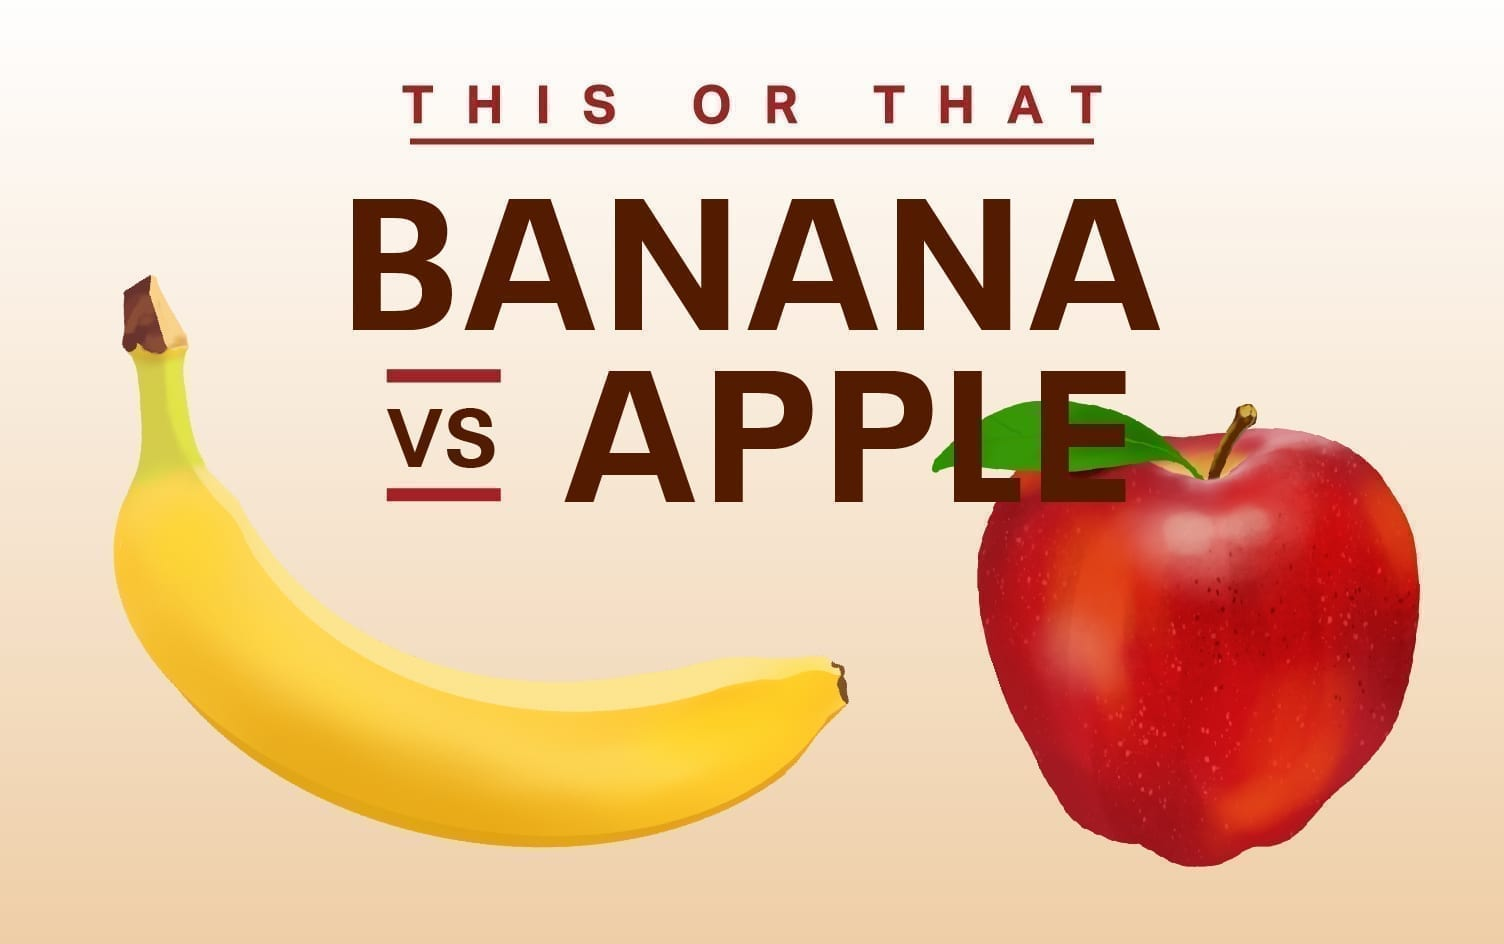

In [4]:
Image(filename=r'C:\Users\Yiyi.Luo\Desktop\UACF-This-or-That-Apple-Banana-02.jpg')

**Dataset**:

| Fruit ID | Size   | Color  | Class (Fruit Type) |
|----------|--------|--------|-------------------|
| 1        | Small  | Red    | Apple (0)         |
| 2        | Medium | Red    | Apple (0)         |
| 3        | Large  | Green  | Apple (0)         |
| 4        | Medium | Yellow | Banana (1)        |
| 5        | Large  | Yellow | Banana (1)        |
| 6        | Small  | Green  | Apple (0)         |
| 7        | Small  | Yellow | Banana (1)        |
| 8        | Medium | Green  | Apple (0)         |ple (0)


**Encoded Dataset**:

| Fruit ID | Size | Color | Class (Fruit Type) |
|----------|------|-------|-------------------|
| 1        | 1    | 1     | 0                 |
| 2        | 2    | 1     | 0                 |
| 3        | 3    | 2     | 0                 |
| 4        | 2    | 3     | 1                 |
| 5        | 3    | 3     | 1                 |
| 6        | 1    | 2     | 0                 |
| 7        | 1    | 3     | 1                 |
| 8        | 2    | 2     | 0                 |

---

## 1.2. Residuals Calculation

Residuals represent the errors between the actual values and the model's predictions. In gradient boosting, these residuals are treated as the target for the next tree. The subsequent tree learns to predict these residuals using the features.

| Fruit ID | Actual Class (yiy_iyi) | Predicted Probability | Residual           |
|----------|------------------------|----------------------|-------------------|
| 1        | 0                      | 0.375                | 0 - 0.375 = -0.3750 |
| 2        | 0                      | 0.375                | 0 - 0.375 = -0.3750 |
| 3        | 0                      | 0.375                | 0 - 0.375 = -0.3750 |
| 4        | 1                      | 0.375                | 1 - 0.375 = 0.6250  |
| 5        | 1                      | 0.375                | 1 - 0.375 = 0.6250  |
| 6        | 0                      | 0.375                | 0 - 0.375 = -0.3750 |
| 7        | 1                      | 0.375                | 1 - 0.375 = 0.6250  |
| 8        | 0                      | 0.375                | 0 - 0.375 = -0.3750 |


### Interpretation of Residuals

#### Residual of -0.375
- **Occurs when**: The actual class is Apple (0)
- **Meaning**: The model overestimated the probability of being a Banana
- **Interpretation**: The model predicted a 37.5% chance of being a Banana, but it's actually an Apple
- **Action needed**: Decrease the predicted probability for this instance

#### Residual of 0.625
- **Occurs when**: The actual class is Banana (1)
- **Meaning**: The model underestimated the probability of being a Banana
- **Interpretation**: The model predicted a 37.5% chance of being a Banana, and it is indeed a Banana
- **Action needed**: Increase the predicted probability for this instance

### Importance of Residuals

1. **Purpose**: Indicate errors in the model's predictions
2. **Guide Corrections**:
   - Negative Residuals (-0.375): Model needs to reduce predicted probability
   - Positive Residuals (0.625): Model needs to increase predicted probability

### Influence on the Next Tree

- Residuals become target values for training the next tree
- The tree learns patterns in features (Size, Color) to correct predictions

### Analogy for Understanding

Imagine a guessing game:
1. **Task**: Guess a number between 0 and 1 representing the probability of a fruit being a Banana
2. **Initial Guess**: 0.375 for all fruits
3. **Feedback**:
   - If Apple (0): Guess of 0.375 is too high → Negative feedback of -0.375
   - If Banana (1): Guess of 0.375 is too low → Positive feedback of 0.625
4. **Adjustments**:
   - For Apples: Decrease your next guess
   - For Bananas: Increase your next guess

This process helps refine predictions in subsequent iterations.

### Next Steps

- Use features (Size, Color) to adjust predictions
- Trees learn patterns to increase or decrease probabilities appropriately
- This iterative process continues, with each tree focusing on correcting the errors of the previous trees

---

## 1.3. Splitting Nodes and Features

### 1.3.1. Features Drive Splits
- **Splitting Based on Features**: The tree uses features to split the data into groups with similar residuals.
- **Leaf Values Adjust Predictions**: Each leaf assigns a value that adjusts the model's predictions in the direction needed to minimize the loss.
- **Learning from Patterns**: For example, the model might learn that yellow fruits are more likely bananas, while red and green fruits are more likely apples.

### 1.3.2. Node Splitting Criteria

- **Evaluate All Possible Splits**: For each feature and potential split point (at bin boundaries


- **Calculate the Gain**: Gain is the reduction in the loss function that would result from the split. It involves computing statistics like sums of gradients and sums of squared gradients (via Hessianplit

- **Maximize Gain**: Choose the split that results in the largest reduction of the loss fuction.

- **Effect on Residuals**: The ideal split separates residuals into groups where they are as similar as possible, often corresponding to minimizing the variance within each child node.

### 1.3.3. Goal in Splitting Nodes
- **Maximizing Loss Reduction**: The primary goal when splitting nodes is to find splits that maximize the reduction in the loss function.
- **Low Variance in Residuals**: This often corresponds to creating child nodes where residuals are as similar as possible (i.e., low variance). Low Variance in Residuals: When residuals within a node have low variance, the model can make a consistent adjustment for all instances in that node. This adjustment moves the predictions closer to the actual values. High Variance in Residuals: When the variance is high, it's harder to find a single adjustment that fits all instances in the node. The model's corrections may be less effective.
- **Selecting the Best Split**: The ideal split separates residuals into groups where they are as homogeneous as possible, facilitating effective adjustments.

---

## 1.4. Basic Concepts

### 1.4.1. Residuals

### 1.4.2. Loss Function
- **Purpose**: The loss function measures the discrepancy between the predicted outputs and the actual outputs. It not only quantifies the prediction error but is also sensitive to the confidence of predictions.
- **Sensitivity to Confidence**: In classification tasks, the loss function penalizes not just incorrect predictions but also how confident the model is in those incorrect predictions.
- **Example**: Mean Squared Error (MSE) in regression tasks calculates the degree of error between predicted outputs and actual outputs.

### 1.4.3. Gradient and Hessian
- **Gradients (First-Order Derivatives)**: The residuals are the gradients of the loss function with respect to the predictions.
- **Hessians (Second-Order Derivatives)**: The algorithm uses both gradients and second-order derivatives (Hessians) to find the best splits. This second-order information allows for more accurate estimation of loss reduction and better split decisions.
- **Benefit**: This allows for more accurate estimation of the loss reduction and better split decisions, improving the model's performance.
- **Gain Calculation**: A higher gain indicates a better split. The gain is calculated using the sums of gradients and Hessians in potential splits.

---

## 1.5. What Happens After the Model Picks the Best Split Point: Iterative Refinement and Combining Trees

- **Correcting Residuals**: Subsequent trees continue to use features to correct residuals from the previous iterations.
- **Ensemble Model**: Each tree contributes to the final prediction, and the combination of all trees forms the ensemble model.
- **Continuous Improvement**: Each tree built in the sequence focuses on correcting the errors of the previous ensemble of trees. This iterative process continues until the model reaches a desired level of accuracy.

### Recursive Tree Growth in LightGBM

After LightGBM selects the best split point based on the histogram bins, it doesn't stop there. The model continues to grow the tree recursively by:

- **Creating Child Nodes:** The data is partitioned into left and right child nodes based on the best split.
- **Repeating the Splitting Process:** For each child node, LightGBM repeats the process of finding the best split using the same histogram-based approach.
- **Using Bins at Each Level:** The binning process is applied within each child node independently. Even though the initial bins are based on the entire dataset, the distribution of data within each node may differ, affecting how the bins are utilized in subsequent splits.

### Key Points

- **Refinement Through Multiple Splits:** Even though the initial split is based on bins, subsequent splits can further refine the separation of data, effectively "diving into" the bins to improve accuracy.
- **Reusing Binning Strategy:** The histogram bins are a tool to speed up computation but don't limit the tree's depth or the model's ability to capture complex patterns.
- **Splitting on the Same Feature Multiple Times:** LightGBM can split on the same feature multiple times at different levels of the tree, allowing for nuanced decision boundaries.

### Example

- Suppose the first split is on **Color ≤ 2.5**, separating apples and bananas.
- In the left child node (apples), the model may then find the best split on **Size ≤ 1.5**.
- This process continues recursively until stopping criteria are met (e.g., maximum depth, minimum number of samples in a node).

---

# 2. Key Features in Light GBM

## 2.1. Histogram-Based Decision Tree Learning
- **Purpose**: Instead of evaluating every possible split point, LightGBM discretizes continuous features into a fixed number of bins (histograms). This reduces the number of potential split points and speeds up computation.
- **How It Works**:
#### a. Bin Construction
- **For Each Feature**:
  - The feature values are sorted.
  - The range of values is divided into **k** bins (e.g., 255 bins by default).
  - Each feature value is assigned to a bin based on its value.
- **Result**: Each feature is represented by a histogram of bin counts.
#### b. Statistics Collection
- **For Each Bin**:
  - Accumulate the sum of gradients and Hessians (second-order gradients) for instances falling into that bin.
  - These statistics are used to evaluate the potential splits.
#### c. Split Finding
- **For Each Feature**:
  - Use the histogram to evaluate possible splits at bin boundaries.
  - Compute the gain (reduction in the loss function) for splits between bins.
- **Across All Features**:
  - Compare the best splits from each feature.
  - Select the split with the highest gain.

---

## 2.2. Exclusive Feature Bundling (EFB)

- **Key Idea**: Reduce the number of features by combining mutually exclusive features without losing information.

### What Are Mutually Exclusive Features?

- **Definition**: Features that are sparse and rarely non-zero at the same time.
- **Common in High-Dimensional Data**: For example, one-hot encoded categorical features.

### How EFB Works

#### a. Feature Analysis

- Identify features that are mutually exclusive.

#### b. Feature Bundling

- Combine these features into a single feature (bundle).
- The combined feature takes on different values to represent the original features.

#### c. Split Finding on Bundles

- When evaluating splits, LightGBM can decode which original feature the value corresponds to.

### Benefits

- **Reduces Number of Features**: Fewer features mean fewer histograms and less computation.
- **Preserves Information**: No significant loss of information because original features are mutually exclusive.tures are mutually exclusive.

---

## 2.3. Built-in Regularization in LightGBM

### How Many Built-in Functions Like L1 and L2 Does LightGBM Have?

LightGBM includes several built-in features and regularization techniques that help prevent overfitting and enhance model performance:

#### Regularization Parameters:

- **lambda_l1:** L1 regularization term on weights. It can help induce sparsity in the model.
- **lambda_l2:** L2 regularization term on weights. It can prevent overfitting by penalizing large weights.
- **min_gain_to_split:** The minimum loss reduction required to make a split. It acts as a regularization parameter to prevent creating insignificant splits.

#### Default Settings and Automatic Handling:

- **Optimized Defaults:** LightGBM comes with default parameter values that are well-tuned for many problems.
- **Automatic Feature Handling:** It handles categorical variables, missing values, and overfitting prevention out of the box.

#### Other Built-in Features:

- **Early Stopping:** Stops training when the model's performance on a validation set stops improving.
- **Feature Fraction (feature_fraction):** Controls the fraction of features to consider when looking for the best split.
- **Bagging Fraction (bagging_fraction) and Bagging Frequency (bagging_freq):** Used for subsampling the data to prevent overfitting.

### Why One Could Get Good Results Without Much Tuning:

- **Robust Defaults:** The default parameters in LightGBM are designed to work well across a variety of datasets.
- **Built-in Regularization:** Even without explicit tuning, LightGBM applies regularization techniques that help prevent overfitting.
- **Efficient Algorithms:** LightGBM's algorithms are optimized for speed and performance, which can lead to good results quickly.

### Takeaway:

- **Out-of-the-Box Performance:** It's possible to achieve strong results with LightGBM without extensive parameter tuning due to its thoughtful defaults and built-in functionalities.
- **Customization for Improvement:** While defaults work well, further tuning of parameters like regularization terms, learning rate, and tree complexity can lead to even better performance tailored to your specific dataset.

---

## 2.4. Built-in Function Handling Missing Values in LightGBM

### 2.4.1. Filling NaNs with Negative Values: Benefits and Drawbacks

#### Potential Benefits:
- **Separate Bin for Missing Values:** Negative values will form a separate bin, potentially allowing the model to handle missing data distinctly.

#### Potential Drawbacks:
- **Introducing Bias:** Artificially assigning a value may introduce bias if negative values don't naturally occur in the data.
- **Misrepresenting Data:** Negative placeholders may mislead the model into interpreting missingness as a meaningful negative value.
- **Loss of Missingness Information:** The fact that a value is missing is itself informative and might be better handled explicitly.

### 2.4.2. LightGBM's Native Handling of Missing Values

- **Automatic Handling:** LightGBM can handle missing values natively without the need to impute or fill them.
- **Best Direction for Missing Values:** During training, when considering a split, LightGBM decides whether missing values should go to the left or right child node based on which option minimizes the loss.
- **Efficiency in Splitting:** This method allows the model to learn patterns associated with missingness directly, potentially improving performance.
- **Preserves Missingness Information:** Missing values may carry information (e.g., missing income data might be indicative in fraud detection), and LightGBM leverages this.
- **Simplifies Preprocessing:** Eliminates the need for manual imputation or complex preprocessing steps.

### 2.4.3. Implementation Details

- **Sparse Features Handling:** LightGBM is efficient with sparse data and treats zeros and missing values appropriately.
- **Flexibility:** The model can capture interactions between missingness and other features.

### 2.4.4. Recommendations

- **Use Default Missing Value Handling:** Rely on LightGBM's native capability to manage missing values effectively.
- **Avoid Artificial Imputation:** If you choose to impute missing values, ensure that the method aligns with the data's nature and doesn't introduce unintended artifacts.
- **Monitor Performance:** While LightGBM handles missing values well, it's still good practice to monitor model performance and consider additional preprocessing if necessary.

---

# 3. Data Preprocessing Goals and Tips

## 3.1. Data Cleaning and Normalization

### 3.1.1. Data Cleaning

Ensure the dataset is accurate and consistent:

- **Remove Duplicates**: Identify and eliminate duplicate records that may bias the model.
- **Correct Errors**: Fix typos, incorrect entries, or inconsistencies in categorical labels.
- **Standardize Formats**: Ensure consistency in data formats, units, and scales.
- **Tip**: Consistent and accurate data is foundational for any machine learning model's success.

### 3.1.2. Normalize or Scale Features (When Appropriate)

While tree-based models like LightGBM don't require feature scaling, in some cases, normalization can help:

- **When to Scale**: If you have features on vastly different scales and suspect it may impact the model's performance.
- **Scaling Methods**:
  - Standardization: Subtract mean and divide by standard deviation.
  - Normalization: Scale features to a [0, 1] range.
- **Tip**: Generally, scaling is not necessary for LightGBM, but it won't harm the model if applied thoughtfully.

---

## 3.2. Handle Missing Values Appropriatelylues

While LightGBM can handle missing values natively, preprocessing missing data can still improve model perfor 
ance:

- **Analyze Missingness**:
  - Understand Patterns: Determine if data is missing at random or if there's a pattern.
  - Feature Engineering: Consider creating an indicator variable that flags missing values, allowing the model to learn from the missingness itself.

- **Imputation Techniques**:
  - Mean/Median Imputation: For numerical features, replace missing values with the mean or median.
  - Mode Imputation: For categorical features, replace missing values with the mode.
  - Advanced Imputation: Use algorithms like K-Nearest Neighbors (KNN) or iterative imputation for more sophisticated estimates.

- **Tip**: Always be cautious when imputing to avoid introducing bias. Sometimes, letting LightGBM handle missing values is the best approach.

---

## 3.3. Encode Categorical Variables Effectively

LightGBM can handle categorical features directly, but proper encoding can still enhance performance:

- **Categorical Feature Specification**:
  - When using LightGBM, specify which features are categorical. This allows the model to apply optimal split algorithms for categorical data.

- **Encoding Methods**:
  - Label Encoding: Assign a unique integer to each category.
  - One-Hot Encoding: Create binary columns for each category (be cautious with high cardinality features).
  - Target Encoding: Replace categories with the mean of the target variable for that category (risk of overfitting; use with caution).

- **Tip**: For high-cardinality categorical features, consider combining rare categories or using target encoding with regularization.

---

## 3.4. Handle Class Imbalance

In fraud detection, the dataset is often imbalanced, with far fewer fraudulent cases:

- **Resampling Techniques**:
  - Oversampling: Duplicate or synthesize new instances of the minority class (e.g., SMOTE).
  - Undersampling: Remove instances from the majority class.

- **Adjust Class Weights**:
  - Use the scale_pos_weight parameter in LightGBM to balance the impact of positive and negative samples.

- **Evaluation Metrics**:
  - Use appropriate metrics like Precision, Recall, F1-Score, or Area Under the Precision-Recall Curve (AUPRC) instead of accuracy.

- **Tip**: Always validate the impact of resampling methods using cross-validation to prevent overfitting.

---

## 3.5. Outlier Detection and Handling

Outliers can skew the model's understanding of the data distribution:

- **Identify Outliers**:
  - Use statistical methods (e.g., Z-score, IQR) or visualization techniques (e.g., box plots) to detect outliers.

- **Handle Outliers**:
  - Removal: Exclude outliers if they are errors or not representative.
  - Transformation: Apply transformations (e.g., log, square root) to reduce the impact.
  - Capping/Flooring: Limit the values to a certain range (winsorization).

- **Tip**: In fraud detection, outliers might actually be fraudulent cases. Carefully assess before removing them.

---

## 3.6. Address Multicollinearity

Although tree-based models are less sensitive to multicollinearity, reducing highly correlated features can still be beneficial:

- **Detect Multicollinearity**:
  - Compute correlation matrices to identify highly correlated pairs of features.

- **Feature Selection**:
  - Remove one of the features from highly correlated pairs.

- **Dimensionality Reduction**:
  - Use techniques like PCA if appropriate.

- **Tip**: Be cautious, as removing features may also remove valuable information.

---

## 3.7. Feature Importance, Selection and Dimensionality Reduction

### 3.7.1. Feature Selection and Dimensionality Reduction

Reducing the number of features can help the model focus on the most informative ones:

- **Correlation Analysis**: Remove features that are highly correlated with each other to reduce redundancy.
- **Variance Thresholding**: Eliminate features with little to no variance, as they provide minimal information.
- **Feature Importance**: Use model-based feature importance scores to identify and remove less important features.
- **Dimensionality Reduction Techniques**: Techniques like Principal Component Analysis (PCA) can be used, though they may not be as beneficial for tree-based models.
- **Tip**: Be cautious not to remove features that, while individually weak, may be important in combination wit
 o# rs.

#### 3.7.2. Utilizing Feature Importance

Understanding which features contribute most to the model can guide further preprocessing:

- **Interpret Feature Importances**: Use LightGBM's built-in feature importance plots.
- **Refine Features**: Focus on engineering and cleaning the most important features.
- **Tip**: Features with low importance may be candidates for removal, but consider interactions before making decisions.

### 3.7.3. Feature Creation


Creating new features can help the model capture underlying patterns:

- **Domain Knowledge**:
  - Use your understanding of the data to create meaningful features. For fraud detection, consider features like transaction frequency, average transaction amount, or time since last transacion.

- **Interactions**:
  - Create interaction terms between features that may have a combinedeffect.

- **Datetime Features**:
  - Extract features from timestamps, such as hour of the day, day of the week, or whether a transaction occurred ona weekend.

- **Aggregations**:
  - Compute aggregated statistics (mean, sum, count) over groups, such as customer ID or prouct category.

- **Tip**: Feature engineering can significantly impact model performance, especially in complex tasks like fraud detection.

### 3.7.4. Handle Imbalanced Feature Distribution

If certain features have skewed distributions:

- **Transformation**:
  - Apply logarithmic or Box-Cox transformations to normalize the distribution.

- **Binning**:
  - Discretize continuous variables into bins if it makes sense for the data.

- **Tip**: Normalizing skewed features can help the model learn patterns more effectively.

---

## 3.8. Balance Data Across Subsets (If Segmented)

If you decide to segment your data (e.g., by product type):

- **Ensure Sufficient Data**:
  - Verify that each subset has enough data to train a robust model.

- **Consistent Preprocessing**:
  - Apply the same preprocessing steps across all subsets to maintain consistency.

- **Tip**: Compare the performance of segmented models versus a unified model to determine the best approach.

---

## 3.9. Monitor and Validate Model Performance

Regularly check how preprocessing affects the model:

- **Use Validation Sets**:
  - Keep a separate hold-out set to evaluate the impact of preprocessing seps.

- **Avoid Overfitting**:
  - Monitor for signs of overfitting, such as a large gap between training and validation perfrmance.

- **Performance Metrics**:
  - Choose appropriate metrics that reflect the business objectives (e.g., minimizing false positives in fraud etection).

- **Tip**: Continuous validation helps ensure that preprocessing steps are beneficial.

---

# 4. Model Development

## 4.1. Model Selection

## 4.2. Cross-Validation and Hyperparameter Tuning

Optimizing model parameters ensures the model generalizes well:

- **Cross-Validation**:
  - Use techniques like K-Fold cross-validation to assess model performance reliably.

- **Hyperparameter Optimization**:
  - Adjust parameters like num_leaves, max_depth, learning_rate, and regularization terms (lambda_l1, lambda_l2).

- **Automated Tuning Tools**:
  - Use libraries like Optuna, Hyperopt, or GridSearchCV for systematic tuning.

- **Tip**: Careful tuning can significantly improve model performance beyond default settings.

---

# 5. Evaluation Metrics for Classification

## 5.1. Basic Classification Metrics

- **Accuracy**: The proportion of correct predictions (both true positives and true negatives) among the total number of cases examined.
- **Precision**: The proportion of true positive predictions among all positive predictions.
- **Recall (Sensitivity)**: The proportion of true positive predictions among all actual positive cases.
- **F1 Score**: The harmonic mean of precision and recall, providing a single score that balances both metrics.
- **ROC Score (AUC-ROC)**:
  - **Definition**: The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate against the False Positive Rate at various threshold settings.
  - **AUC-ROC**: The Area Under the ROC Curve (AUC-ROC) provides an aggregate measure of performance across all possible classification thresholds.
  - **Interpretation**: 
    - AUC of 0.5 suggests no discriminative ability (equivalent to random guessing)
    - AUC of 1.0 indicates perfect discrimination
  - **Advantages**:
    - Insensitive to class imbalance
    - Provides a single measure of classifier performance

## 5.2. Using Probabilities vs. Hard Classifications

In many cases, it's preferable to use probabilities rather than hard classifications:

- **Probabilities**: The model's estimated likelihood of a sample belonging to the positive class.
- **Hard Classifications**: Binary outcomes (0 or 1) based on a fixed threshold applied to probabilities.

### Advantages of Using Probabilities:

1. **Flexibility in Threshold Setting**: Allows for adjusting the decision threshold based on specific business needs without retraining the model.
2. **Richer Information**: Provides more nuanced information about the model's confidence in its predictions.
3. **Better for Ensemble Methods**: Easier to combine predictions from multiple models.
4. **Improved Metric Calculation**: Metrics like AUC-ROC and log loss use probabilities for more accurate performance assessment.

## 5.3. Other Important Metrics

- **Precision-Recall Curve**: Similar to ROC but focuses on the trade-off between precision and recall.
- **Log Loss**: Measures the performance of a classification model where the prediction is a probability value between 0 and 1.
- **Confusion Matrix**: A table layout of prediction results, showing the numbers of true positives, false positives, true negatives, and false negatives.

## 5.4. Choosing the Right Metric

The choice of metric depends on your specific problem and goals:

- **Balanced Dataset**: Accuracy might be sufficient.
- **Imbalanced Dataset**: Consider precision, recall, F1 score, or AUC-ROC.
- **Costs of False Positives/Negatives**: Choose metrics that align with the cost structure of errors in your domain.

**Tip**: In fraud detection, where class imbalance is common and the cost of false negatives (missed frauds) might be high, metrics like recall, precision-recall AUC, or custom weighted metrics are often valuable alongside AUC-ROC.

---

# 6. Conclusion